In [4]:
import statsapi
import logging

import pandas as pd
from datetime import datetime

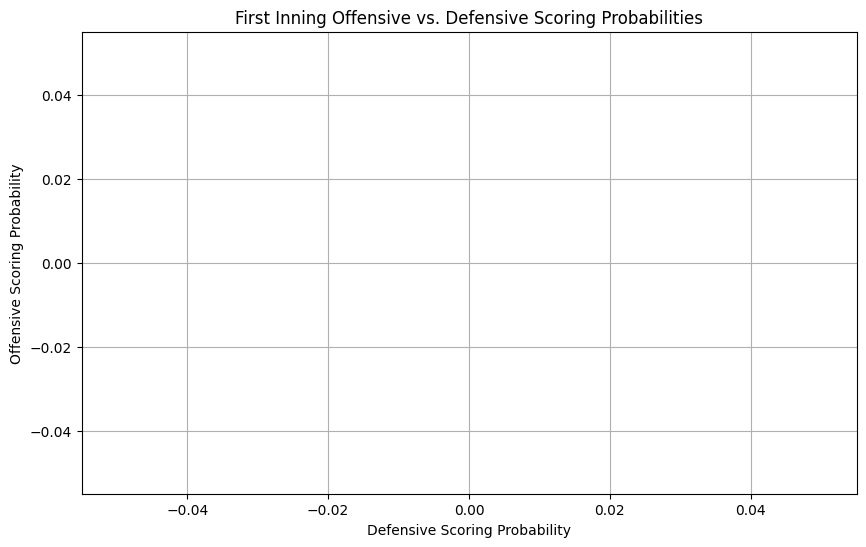

In [3]:
import statsapi
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np  # For NaN values

# Define the period for analysis
start_date = '2023-04-01'
end_date = '2023-04-30'

# Fetch schedule for all games played between start_date and end_date
sched = statsapi.schedule(start_date=start_date, end_date=end_date)

# Prepare dictionaries to hold first inning scores
offensive_scores = {}
defensive_scores = {}

# Fetch linescore for each game and collect first inning data
for game in sched:
    game_id = game['game_id']
    home_team = game['home_name']
    away_team = game['away_name']

    # Initialize team entries in dictionaries
    if home_team not in offensive_scores:
        offensive_scores[home_team] = {'scored': [], 'games': 0}
        defensive_scores[home_team] = {'allowed': [], 'games': 0}
    if away_team not in offensive_scores:
        offensive_scores[away_team] = {'scored': [], 'games': 0}
        defensive_scores[away_team] = {'allowed': [], 'games': 0}

    try:
        linescore = statsapi.linescore(game_id)
        if 'innings' in linescore and isinstance(linescore['innings'], list) and len(linescore['innings']) > 0:
            first_inning = linescore['innings'][0]
            home_runs = first_inning['home']['runs'] if 'home' in first_inning else np.nan
            away_runs = first_inning['away']['runs'] if 'away' in first_inning else np.nan
        else:
            home_runs = np.nan
            away_runs = np.nan
        # Update scoring data
        offensive_scores[home_team]['scored'].append(home_runs > 0 if not np.isnan(home_runs) else np.nan)
        defensive_scores[home_team]['allowed'].append(away_runs > 0 if not np.isnan(away_runs) else np.nan)

        offensive_scores[away_team]['scored'].append(away_runs > 0 if not np.isnan(away_runs) else np.nan)
        defensive_scores[away_team]['allowed'].append(home_runs > 0 if not np.isnan(home_runs) else np.nan)

    except Exception as e:
        print(f"Error fetching linescore for game ID {game_id}: {e}")
    # Increment games count regardless of data validity
    offensive_scores[home_team]['games'] += 1
    defensive_scores[home_team]['games'] += 1
    offensive_scores[away_team]['games'] += 1
    defensive_scores[away_team]['games'] += 1

# Calculate probabilities
probabilities = []
for team in offensive_scores:
    valid_games = len([score for score in offensive_scores[team]['scored'] if not np.isnan(score)])
    off_prob = sum(offensive_scores[team]['scored']) / valid_games if valid_games > 0 else np.nan
    def_prob = sum(defensive_scores[team]['allowed']) / valid_games if valid_games > 0 else np.nan
    probabilities.append((team, off_prob, def_prob))

# Convert to DataFrame for visualization
prob_df = pd.DataFrame(probabilities, columns=['Team', 'Offensive Probability', 'Defensive Probability'])

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(prob_df['Defensive Probability'], prob_df['Offensive Probability'], alpha=0.7)
plt.title('First Inning Offensive vs. Defensive Scoring Probabilities')
plt.xlabel('Defensive Scoring Probability')
plt.ylabel('Offensive Scoring Probability')
plt.grid(True)
for i, team in enumerate(prob_df['Team']):
    plt.annotate(team, (prob_df['Defensive Probability'][i], prob_df['Offensive Probability'][i]))
plt.show()


In [6]:
import re

def parse_box_score(box_score):
    # Extracting inning scores, runs, hits, and errors from the box score string
    lines = box_score.strip().split('\n')
    headers = re.findall(r'\d+', lines[0])  # This should find all inning numbers
    team_scores = {}
    
    for line in lines[1:]:  # Skip the first line which is the header
        parts = line.split()
        team_name = ' '.join(parts[:-len(headers)-3])  # Team name might be two words
        scores = parts[-len(headers)-3:-3]  # The scores for each inning
        runs, hits, errors = parts[-3], parts[-2], parts[-1]
        team_scores[team_name] = {
            'Inning Scores': scores,
            'Runs': runs,
            'Hits': hits,
            'Errors': errors
        }
    
    return team_scores

# Example usage for tests:
box_score_data = """Final     1 2 3 4 5 6 7 8 9  R   H   E  
White Sox 0 1 0 2 0 0 0 0 1  4   10  1  
Astros    2 0 0 1 0 0 1 2 0  6   11  0"""
parsed_data = parse_box_score(box_score_data)
print(parsed_data)


{'White Sox': {'Inning Scores': ['0', '1', '0', '2', '0', '0', '0', '0', '1'], 'Runs': '4', 'Hits': '10', 'Errors': '1'}, 'Astros': {'Inning Scores': ['2', '0', '0', '1', '0', '0', '1', '2', '0'], 'Runs': '6', 'Hits': '11', 'Errors': '0'}}
